In [12]:
import numpy as np 
import pandas as pd 
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt 

In [13]:
# # Data inladen
df = pd.read_csv("encoded_df.csv")
print(df.head())

# Eerst de data opschudden om bias te voorkomen
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Zorg ervoor dat elke ervaring, geslacht en gewichtsklasse in elke set vertegenwoordigd zijn
train_data = pd.DataFrame()
val_data = pd.DataFrame()
test_data = pd.DataFrame()

for ervaring in df['ervaring_0'].unique():
    for geslacht in df['geslacht_M'].unique():
        for gewichtsklasse in df['gewichtsklasse_Z'].unique():
            subset = df[(df['ervaring_0'] == ervaring) & (df['geslacht_M'] == geslacht) & (df['gewichtsklasse_Z'] == gewichtsklasse)]
            if not subset.empty:
                temp_train, temp_temp = train_test_split(subset, test_size=0.3, random_state=42)
                temp_val, temp_test = train_test_split(temp_temp, test_size=0.3, random_state=42)
                train_data = pd.concat([train_data, temp_train])
                val_data = pd.concat([val_data, temp_val])
                test_data = pd.concat([test_data, temp_test])

# Reset indexen
train_data.reset_index(drop=True, inplace=True)
val_data.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)

# Controleren op juiste verdeling
print(f"Trainingsdata: {len(train_data)} rijen")
print(f"Validatiedata: {len(val_data)} rijen")
print(f"Testdata: {len(test_data)} rijen")

# # Optioneel: data opslaan in aparte bestanden
# train_data.to_csv('enc_train_data.csv', index=False)
# val_data.to_csv('enc_val_data.csv', index=False)
# test_data.to_csv('enc_test_data.csv', index=False)

   500_split  2k tijd  geslacht_M  geslacht_V  gewichtsklasse_L  \
0        104      379           1           0                 0   
1        104      379           1           0                 0   
2        104      379           1           0                 0   
3        104      379           1           0                 0   
4        104      379           1           0                 0   

   gewichtsklasse_Z  ervaring_0  ervaring_1  binary_trainingtype_0  \
0                 1           0           1                      1   
1                 1           0           1                      1   
2                 1           0           1                      1   
3                 1           0           1                      1   
4                 1           0           1                      1   

   binary_trainingtype_1  ...  binary_trainingtype_1101  \
0                      0  ...                         0   
1                      0  ...                         0   

len test nu: 391
most fitting lambda: 0.1
MSE: 68.51367764064048
RMSE: 8.2772989338697
MAE: 6.462892053253484
R-squared: 0.9333341016410862
         y_pred  y_test  pred - test
0    420.201809     427    -6.798191
1    425.019077     420     5.019077
2    428.015885     418    10.015885
3    423.587587     427    -3.412413
4    429.560573     427     2.560573
..          ...     ...          ...
386  384.916438     381     3.916438
387  387.053556     379     8.053556
388  386.347929     389    -2.652071
389  384.271927     382     2.271927
390  380.396691     381    -0.603309

[391 rows x 3 columns]


/home/imme/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:2385: FutureWarning: 'store_cv_values' is deprecated in version 1.5 and will be removed in 1.7. Use 'store_cv_results' instead.
  warnings.warn(
/home/imme/miniconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:110: FutureWarning: Attribute `cv_values_` is deprecated in version 1.5 and will be removed in 1.7. Use `cv_results_` instead.
  warnings.warn(msg, category=FutureWarning)


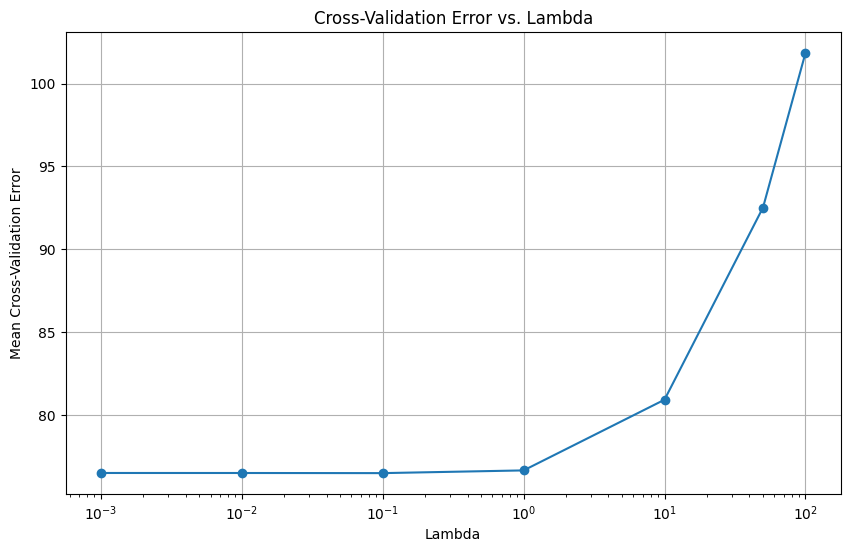

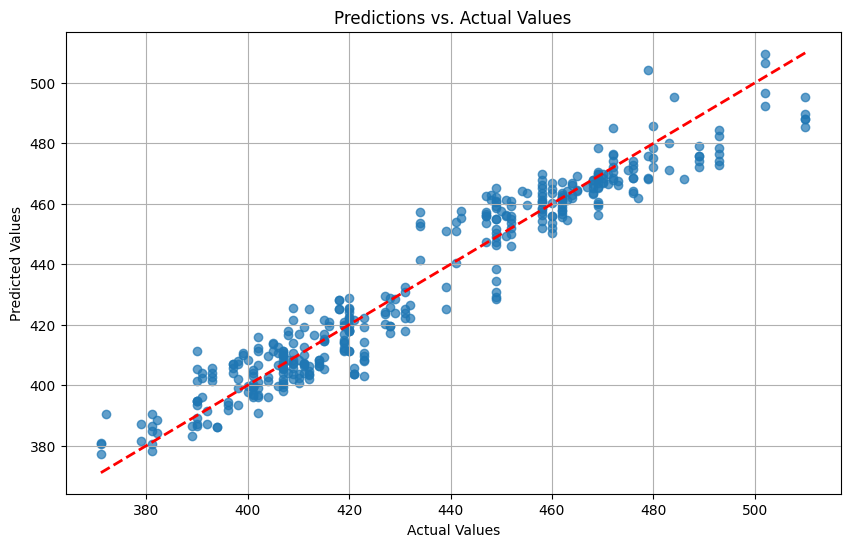

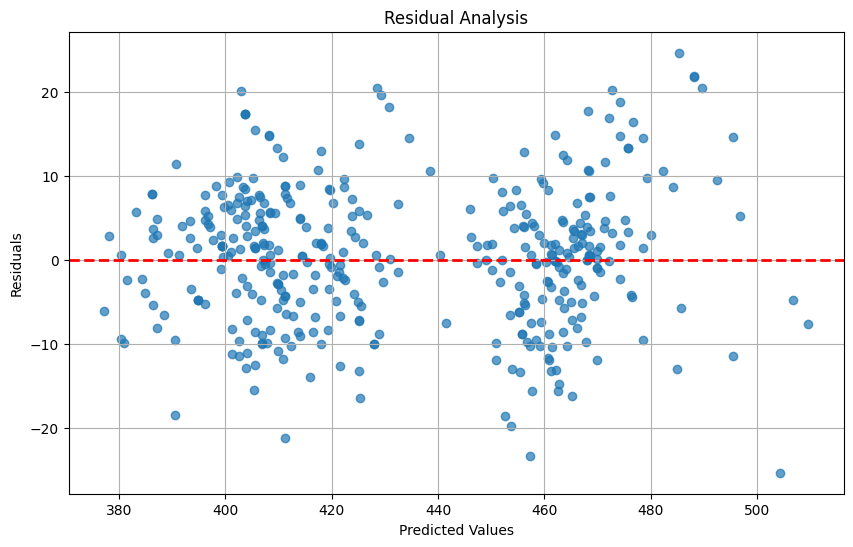

In [14]:
X_train = train_data.drop(columns=['2k tijd'])
y_train = train_data['2k tijd']

X_val = val_data.drop(columns=['2k tijd'])
y_val = val_data['2k tijd']

X_test = test_data.drop(columns=['2k tijd'])
y_test = test_data['2k tijd']

print(f'len test nu: {len(X_test)}')

# align train and test sets, so they have same amount of rows
X_train, X_val = X_train.align(X_val, join='outer', axis=1, fill_value=0)
X_train, X_test = X_train.align(X_test, join='outer', axis=1, fill_value=0)

# Via crossvalidation, find the best value for lambda 
poss_lam = [0.001, 0.01, 0.1, 1.0, 10.0, 50.0, 100.0]

ridge_cv_model = RidgeCV(alphas=poss_lam, store_cv_values=True)

# Fit the model on the training data
ridge_cv_model.fit(X_train, y_train)

# Print the best lambda value
print(f"most fitting lambda: {ridge_cv_model.alpha_}")

# Train the ridge model with the best lambda (alpha) from RidgeCV
ridge_model = Ridge(alpha=ridge_cv_model.alpha_)  # Gebruik de gevonden alpha van RidgeCV
ridge_model.fit(X_train, y_train)

# Predict on the test set
y_pred = ridge_model.predict(X_test)

# Calculate MSE, RMSE, MAE, and R-squared
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the evaluation metrics
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R-squared: {r2}")

print(pd.DataFrame({'y_pred': y_pred, 'y_test': y_test, 'pred - test': y_pred - y_test}))

import matplotlib.pyplot as plt

cv_errors = np.mean(ridge_cv_model.cv_values_, axis=0)

# Plot 1: Cross-validation results
plt.figure(figsize=(10, 6))
plt.plot(poss_lam, cv_errors, marker='o')
plt.xscale('log')
plt.xlabel('Lambda')
plt.ylabel('Mean Cross-Validation Error')
plt.title('Cross-Validation Error vs. Lambda')
plt.grid(True)
plt.show()

# Plot 2: Predictions vs. Actual Values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', linewidth=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predictions vs. Actual Values')
plt.grid(True)
plt.show()

# Plot 3: Residual Analysis
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.7)
plt.axhline(0, color='red', linestyle='--', linewidth=2)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Analysis')
plt.grid(True)
plt.show()


In [11]:
print('hello')

hello
